In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv(f'../03.dataset/TPE_model_features_clean.csv')

In [3]:
data_class = pd.get_dummies(data['鄉鎮市區'])
#data = data.loc[data['交易標的'] == 0]
data_class.columns = ['鄉鎮市區_' + str(x) for x in data_class.columns]
data = pd.concat([data, data_class], axis = 1)
print(data.shape[1])

116


In [4]:
data.insert(data.shape[1], 'y', data['單價元平方公尺'])
data.drop(['單價元平方公尺'],axis=1,inplace=True)
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(['Unnamed: 0.1'],axis=1,inplace=True)
data.drop(['Unnamed: 0.2'],axis=1,inplace=True)
data.drop(['鄉鎮市區'],axis=1,inplace=True)
#data = data.loc[data['備註'].isnull()]
#data.drop(['備註'],axis=1,inplace=True)
data.drop(['geometry'],axis=1,inplace=True)

In [5]:
data = data.loc[:, data.std() > 0]
data = data.dropna()

In [6]:
data.head()

,交易標的,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,有無管理組織,主建物面積,附屬建物面積,陽台面積,電梯,屋齡,...,鄉鎮市區_內湖區,鄉鎮市區_北投區,鄉鎮市區_南港區,鄉鎮市區_士林區,鄉鎮市區_大同區,鄉鎮市區_大安區,鄉鎮市區_文山區,鄉鎮市區_松山區,鄉鎮市區_萬華區,y
0,0,3,1,1,0,89.66,0.00,14.45,0,32.0,...,1,0,0,0,0,0,0,0,0,134473.0
1,0,3,2,2,0,116.82,0.00,13.56,0,40.0,...,0,0,0,0,0,1,0,0,0,107378.0
2,0,1,1,1,1,19.08,1.82,4.56,0,15.0,...,0,0,0,0,0,0,0,0,0,159670.0
3,0,1,0,1,1,30.81,0.00,0.00,0,33.0,...,0,0,0,0,0,0,0,0,0,105030.0
4,0,2,2,1,0,61.15,1.72,14.90,1,0.0,...,0,0,0,1,0,0,0,0,0,178855.0


In [7]:
test_data = data.loc[data['交易年份'] >= 111]
train_data =  data.loc[data['交易年份'] < 111]
#train_data = train_data.loc[data['交易年份'] > 107]

In [8]:
feature_count = data.shape[1]
print(feature_count)

108


In [9]:
#from sklearn.preprocessing import StandardScaler

In [10]:
#scaler = StandardScaler()
#scaler.fit(train_data)

In [11]:
#data_norm = scaler.transform(train_data)
#pd.DataFrame(data_norm).describe()

In [12]:
#X = data_norm[:,0:115]
#y = data_norm[:,115]
#X = data_norm[:,0:feature_count-1]
#y = data_norm[:,feature_count-1]

In [13]:
mean = train_data.mean()
std = train_data.std()
train_data = (train_data-mean)/std

In [14]:
X_train = np.array(train_data.drop('y', axis='columns'))
y_train = np.array(train_data['y'])

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4)

In [17]:
from sklearn.neural_network import MLPRegressor

In [18]:
model_mlp = MLPRegressor(max_iter = 400,activation='relu', hidden_layer_sizes=(int(data.shape[1]*1/2),int(data.shape[1]*1/4)))
model_mlp.fit(X_train, y_train)
mlp_score=model_mlp.score(X_train,y_train)

In [19]:
test_data = (test_data - mean) / std
#test_data = test_data.loc[test_data['y'] >= 3]
X_test = np.array(test_data.drop('y', axis='columns'))
y_test = np.array(test_data['y'])

In [20]:
print('score:',mlp_score)
result = model_mlp.predict(X_test)

score: 0.8838398668070061


In [21]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': result})
df1 = df.head(10)
df1

,Actual,Predicted
0,-0.989601,-0.326160
1,1.315203,2.156802
2,-0.092230,-0.150150
3,0.651602,0.623226
4,-0.313998,-0.549059
5,0.686458,0.821840
6,0.053833,0.385699
7,0.500445,0.631904
8,-1.220107,-0.874834
9,1.236391,0.939437


C:\Users\tazz4\anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

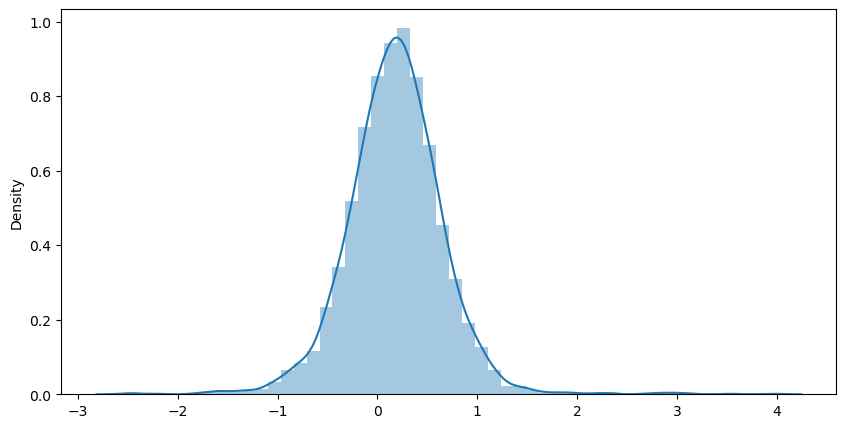

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10,5))
residuals = (y_test- result)
sns.distplot(residuals)

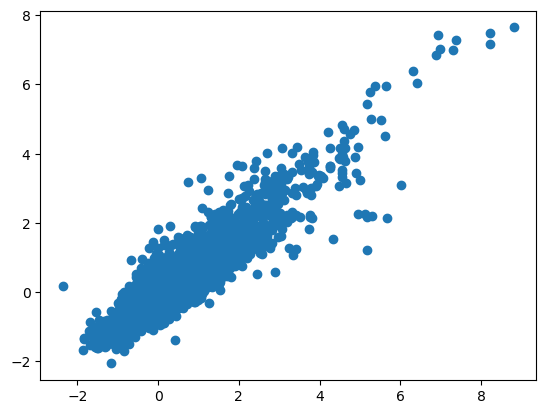

In [23]:
plt.scatter(y_test, result)
plt.plot([0,1],[0,1])

In [24]:
data1 = pd.DataFrame({'origin':y_test * std['y'] + mean['y'],'predict':result* std['y'] + mean['y'],
                     'residual':(y_test * std['y'] + mean['y']) - (result* std['y'] + mean['y'])})
percentage_error = np.mean(np.abs(data1['origin'] - data1['predict'])) / np.mean(data1['origin']) * 100
data1['residual_abs'] = data1['residual'].abs()
data1['y10'] = data1['origin'] / 10 - data1['residual_abs']
data1['y20'] = data1['origin'] / 5 - data1['residual_abs']
data1['y30'] = data1['origin'] / 3.333 - data1['residual_abs']
data1.loc[data1['y10'] >= 0, 'y10'] = 1
data1.loc[data1['y10'] < 0 , 'y10'] = 0
data1.loc[data1['y20'] >= 0, 'y20'] = 1
data1.loc[data1['y20'] < 0 , 'y20'] = 0
data1.loc[data1['y30'] >= 0, 'y30'] = 1
data1.loc[data1['y30'] < 0 , 'y30'] = 0
print(data1)
print(f'預測房價落在實際房價+-10%內的機率為:{data1["y10"].mean()}')
print(f'預測房價落在實際房價+-20%內的機率為:{data1["y20"].mean()}')
print(f'預測房價落在實際房價+-30%內的機率為:{data1["y30"].mean()}')
print("Model Percentage Error: {:.2f}%".format(percentage_error))

        origin        predict      residual  residual_abs  y10  y20  y30
0     120253.0  162317.885833 -42064.885833  42064.885833  0.0  0.0  0.0
1     266387.0  319747.823066 -53360.823066  53360.823066  0.0  0.0  1.0
2     177150.0  173477.598144   3672.401856   3672.401856  1.0  1.0  1.0
3     224312.0  222512.833340   1799.166660   1799.166660  1.0  1.0  1.0
4     163089.0  148185.126107  14903.873893  14903.873893  1.0  1.0  1.0
...        ...            ...           ...           ...  ...  ...  ...
3162  114342.0  104354.742238   9987.257762   9987.257762  1.0  1.0  1.0
3163  191966.0  216730.530045 -24764.530045  24764.530045  0.0  1.0  1.0
3164  199075.0  185938.047668  13136.952332  13136.952332  1.0  1.0  1.0
3165  225828.0  217585.789867   8242.210133   8242.210133  1.0  1.0  1.0
3166  350368.0  294956.086572  55411.913428  55411.913428  0.0  1.0  1.0

[3167 rows x 7 columns]
預測房價落在實際房價+-10%內的機率為:0.5055257341332491
預測房價落在實際房價+-20%內的機率為:0.8512788127565519
預測房價落在實際房價+-30%內的機率

In [25]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print(f"mean_absolute_error: {mean_absolute_error(y_test, result)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, result)}")
print(f"mean_squared_error: {mean_squared_error(y_test, result)}")
print(f"explained_variance_score: {explained_variance_score(y_test, result)}")
print(f"r2_score: {r2_score(y_test, result)}")
#print(f"r2_adj_score: {1 - (1 - r2_score(y_test, result)) * (feature_count - 1) / (df.shape[0] - feature_count - 1)}")

mean_absolute_error: 0.38573801663512897
mean_absolute_percentage_error: 3.629851668251372
mean_squared_error: 0.26437620579426085
explained_variance_score: 0.8404544657356277
r2_score: 0.8185767589818269
